# Cryptocurrency Price Prediction with LSTM

This notebook trains an LSTM model to predict cryptocurrency prices using the processed data with technical indicators.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 2. Load and Prepare Data

In [2]:
# Load the processed data
# Replace with your actual file path
processed_data_file = "processed_btc1.csv"
df = pd.read_csv(processed_data_file)

# Convert 'Open Time' to datetime
df['Open Time'] = pd.to_datetime(df['Open Time'])

# Display the first few rows
print("Data shape:", df.shape)
df.head()

Data shape: (40321, 10)


,Open Time,Close,Volume,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,rsi,macd,macd_signal,upper_band,lower_band
0,2025-02-20 00:00:00,96600.02,5.73579,1.34124,129615.036984,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
1,2025-02-20 00:01:00,96675.65,5.92210,3.89078,375961.068791,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
2,2025-02-20 00:02:00,96600.01,6.15018,1.09753,106083.214470,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
3,2025-02-20 00:03:00,96634.42,5.44832,4.29826,415243.350417,41.052032,-22.027333,-20.362096,96671.839716,96454.866284
4,2025-02-20 00:04:00,96662.89,11.75387,9.62415,930328.082841,41.052032,-22.027333,-20.362096,96671.839716,96454.866284


### 2.1. Check for missing values

In [3]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Fill any remaining missing values
df = df.ffill().bfill()

Missing values per column:
Open Time                       0
Close                           0
Volume                          0
Taker Buy Base Asset Volume     0
Taker Buy Quote Asset Volume    0
rsi                             0
macd                            0
macd_signal                     0
upper_band                      0
lower_band                      0
dtype: int64


### 2.2. Feature Selection and Scaling

In [4]:
# Select features for model training (exclude 'Open Time' as it's not a numeric feature)
feature_columns = ['Close', 'Volume', 'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume',
                    'rsi', 'macd', 'macd_signal', 'upper_band', 'lower_band']
df_features = df[feature_columns]

# Scale the features to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(df_features)

# Create a separate scaler for the target variable ('Close') for later inverse scaling
close_scaler = MinMaxScaler(feature_range=(0, 1))
close_scaler.fit(df[['Close']])

MinMaxScaler()

### 2.3. Create Time Series Dataset

In [5]:
def create_sequences(data, seq_length):
    """
    Create sequences of data for time series prediction
    
    Args:
        data: Scaled feature data
        seq_length: Number of time steps to look back
        
    Returns:
        X: Input sequences (features)
        y: Target values (next closing price)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Feature sequences (all features)
        X.append(data[i:i+seq_length])
        # Target is the next closing price (index 0 since 'Close' is the first column)
        y.append(data[i+seq_length, 0])
    
    return np.array(X), np.array(y)

In [6]:
# Define sequence length (lookback period)
sequence_length = 40  # Look back 60 time steps (adjust as needed)

# Create sequences
X, y = create_sequences(scaled_features, sequence_length)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (40281, 40, 9), y shape: (40281,)


### 2.4. Train-Test Split

In [7]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (32224, 40, 9), (32224,)
Testing data shape: (8057, 40, 9), (8057,)


## 3. Build LSTM Model

In [8]:
def build_lstm_model(input_shape):
    """
    Build an LSTM model for time series prediction
    
    Args:
        input_shape: Shape of input data (sequence_length, num_features)
        
    Returns:
        Compiled Keras model
    """
    model = Sequential()
    
    # First LSTM layer with return sequences for stacking
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Second LSTM layer
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Third LSTM layer
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [9]:
# Get input shape from training data
input_shape = (X_train.shape[1], X_train.shape[2])

# Build the model
model = build_lstm_model(input_shape)

# Display model summary
model.summary()

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 50)         │        12,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,451 (204.89 KB)

 Trainable params: 52,451 (204.89 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train the Model

In [10]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=156,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0354 - val_loss: 2.3680e-04
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0029 - val_loss: 1.4227e-04
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 0.0025 - val_loss: 2.1305e-04
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0022 - val_loss: 2.6878e-04
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - loss: 0.0021 - val_loss: 1.5363e-04
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 0.0019 - val_loss: 2.4029e-04
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0018 - val_loss: 4.8696e-04
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - loss: 0.0018 - val_loss: 9.2422e-05
Epoch 9/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0016 - val_loss: 1.2617e-04
Epoch 10/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - loss: 0.0015 - val_loss: 8.6814e-05
Epoch 11/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0014 - val_loss

### 4.1. Plot Training History

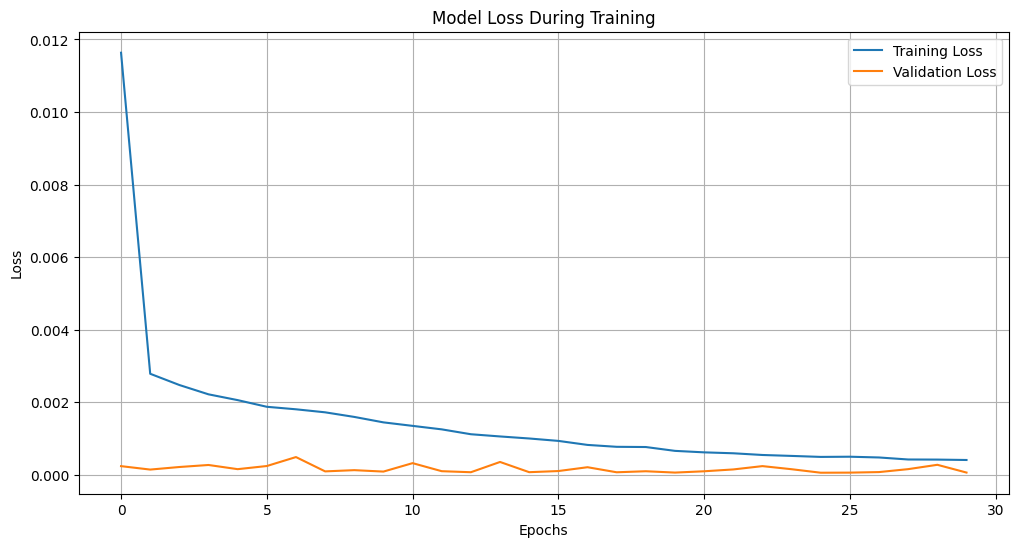

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. Evaluate the Model

In [12]:
# Make predictions on the test set
predicted_scaled = model.predict(X_test)

# Reshape for inverse transformation
predicted_scaled = predicted_scaled.reshape(-1, 1)
y_test_reshaped = y_test.reshape(-1, 1)

# Inverse transform the predictions and actual values to original scale
predicted_price = close_scaler.inverse_transform(predicted_scaled)
actual_price = close_scaler.inverse_transform(y_test_reshaped)

252/252 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [13]:
# Calculate performance metrics
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_price, predicted_price)
r2 = r2_score(actual_price, predicted_price)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 13343.87
Root Mean Squared Error (RMSE): 115.52
Mean Absolute Error (MAE): 88.78
R² Score: 0.9830


### 5.1. Visualize Predictions

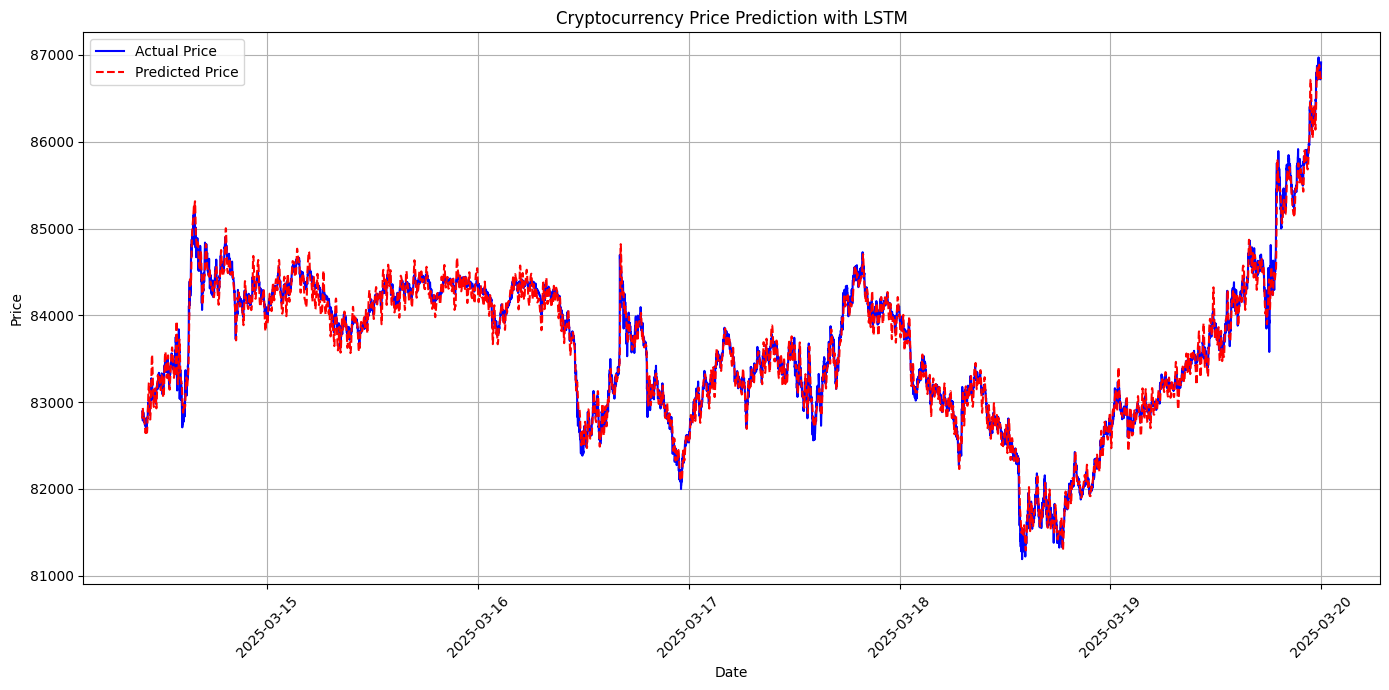

In [14]:
# Create a time index for the test data
test_start_idx = train_size + sequence_length
test_dates = df['Open Time'][test_start_idx:test_start_idx+len(predicted_price)]

# Create DataFrame for plotting
results_df = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual_price.flatten(),
    'Predicted': predicted_price.flatten()
})

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Price', color='blue')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Price', color='red', linestyle='--')
plt.title('Cryptocurrency Price Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Next-Day Price Prediction

In [15]:
def predict_next_price(model, data, sequence_length, feature_scaler, close_scaler):
    """
    Predict the next closing price
    
    Args:
        model: Trained LSTM model
        data: Full dataset
        sequence_length: Number of time steps to look back
        feature_scaler: Scaler used for features
        close_scaler: Scaler used for the target variable
        
    Returns:
        next_price: Predicted next closing price
    """
    # Get the most recent sequence of data
    last_sequence = data[-sequence_length:]
    
    # Scale the sequence
    last_sequence_scaled = feature_scaler.transform(last_sequence)
    
    # Reshape for LSTM input [samples, time steps, features]
    X_new = np.array([last_sequence_scaled])
    
    # Make prediction
    predicted_scaled = model.predict(X_new)
    
    # Inverse transform to get the actual price
    predicted_price = close_scaler.inverse_transform(predicted_scaled)
    
    return predicted_price[0][0]

In [16]:
# Predict the next closing price
next_price = predict_next_price(model, df_features, sequence_length, scaler, close_scaler)

# Get the last known price for comparison
last_known_price = df['Close'].iloc[-1]

print(f"Last known closing price: ${last_known_price:.2f}")
print(f"Predicted next closing price: ${next_price:.2f}")
print(f"Change: ${next_price - last_known_price:.2f} ({((next_price/last_known_price)-1)*100:.2f}%)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Last known closing price: $86913.17
Predicted next closing price: $86766.94
Change: $-146.23 (-0.17%)


## 7. Save the Model

In [17]:
# Save the model
model.save('crypto_lstm_model.h5')

# Save the scalers
import joblib
joblib.dump(scaler, 'feature_scaler.save')
joblib.dump(close_scaler, 'close_scaler.save')

print("Model and scalers saved successfully.")

Model and scalers saved successfully.


## 8. Conclusion

In this notebook, we:

1. Loaded cryptocurrency data with technical indicators
2. Prepared time series sequences for LSTM modeling
3. Built and trained a multi-layer LSTM model
4. Evaluated the model's performance
5. Made a next-day price prediction

The model can be further improved by:
- Hyperparameter tuning
- Adding more features
- Experimenting with different architectures (GRU, Bidirectional LSTM)
- Including more data points for training